# Implementação das Formulações Meb_V e Meb_L para o problema da Máxima Interseção Entre K-Subconjuntos

Equipe: João Victor Amarante Diniz e Maria Sofia Jeronimo de Lima

## Sobre o problema

O Problema da Máxima Interseção de $k$-Subconjuntos (**KMIS**) pode ser definido como: Dado uma coleção $\mathcal{S}$ de subconjuntos do conjunto finito $B$ e um inteiro $k$, deseja-se selecionar $k$ subconjuntos $S_1, S_2, \ldots, S_k \in \mathcal{S}$, tal que  $|S_1 \cap \ldots \cap S_k|$ seja máximo.

O problema pode ser modelado com um grafo bipartido $G=(L \cup R, E)$, sendo que cada vértice $u \in L$ está associado a um subconjunto $S_u \in \mathcal{S}$ e cada vértice $v \in R$ está associado a um elemento $b_v \in B$. Existe uma aresta entre um vértice $u$ (associado a um subconjunto $S_u \in \mathcal{S}$) e um vértice $v$ (relacionado a um elemento $b_v \in B$), se e somente se, $b_v \in S_u$. Portanto, queremos determinar $L' \subset L$, com $|L'| = k$, de forma que $|\cap(L')|$ seja máximo, onde $\cap(L') = \bigcap_{u \in L'} N_G(u)$, com $N_G(u)$ sendo a vizinhança de $u$ em $G$. Por simplicidade, iremos cometer o seguinte abuso de notação: algumas vezes iremos nos referir aos vértices de $L$ pelos subconjuntos $S_u \in \mathcal{S}$ e mesmo denomina-los de vértices ou de subconjuntos.

## Instalação do Solver

In [3]:
! pip install ortools

In [4]:
# Realizando todas as importações necessárias
from ortools.linear_solver import pywraplp
import pandas as pd
import time
import networkx as nx
import matplotlib.pyplot as plt

## Formulação MEB_V

Para a formulação $MEB \ V$, as seguintes variáveis são definidas:

$
y_u = \text{ quantidade de vértices de } u \text{ que pertencem a solução, sendo que } u\in L. \\
z_u =
\begin{cases}
1, \text{ caso o vértice } u \text{ faça parte da solução } \\
0, \text{ caso contrário.}
\end{cases}
$

E, com base nessas definições, tem-se a seguinte formulação:

$$\text{maximize} \frac{1}{k} \sum_{u \in L} y_u$$
sujeito a:
$$\begin{array}{lll}
z_u + z_v \leq 1, & ∀u \in L \text{ e } \forall v \in \overline{N}(u) & (1) \\
y_u \leq d(u)z_u, & \forall u \in L & (2) \\
y_u \leq \sum_{v \in N(u)} z_v, & \forall u \in L & (3) \\
\sum _{u \in L} z_u = k & & (4) \\
y_u \geq 0, & \forall u \in L & (5) \\
z_u \in \{0, 1\}, & \forall u \in R & (6)
\end{array}$$

### Implementação em Python

In [16]:
def solve_meb_v_kmis(G, n, m, k):
  L, R = list(range(n)), list(range(n + m))

  # Instanciando o solver
  solver = pywraplp.Solver.CreateSolver('SCIP')

  if not solver:
      return None, G, [], [], None

  # Criando variáveis de decisão
  y = [solver.IntVar(0.0, 1.0, f'y{i}') for i in L]
  z = [solver.IntVar(0.0, 1.0, f'z{i}') for i in R]

  # Função objetivo
  solver.Maximize(1/k * (sum(z[v] for v in R)))
  objective = solver.Objective()
  for node in range(n+m):
      objective.SetCoefficient(z[node], 1)
  objective.SetMaximization()

  # Restrição 1: se um vértice u em L for escolhido, nenhum vértice que não seja vizinho dele pode ser selecionado
  for u in L:
      for v in R:
          if not G.has_edge(u, v):
              solver.Add(y[u] + z[v] <= 1)

  # Restrição 2: a quantidade máxima de vizinhos de u pertencentes à solução deve ser o grau de u
  for u in L:
      solver.Add(sum(z[v] for v in R if G.has_edge(u, v)) <= G.degree(u))

  # Restrição 3: y_u não pode ser maior que a quantidade de vértices vizinhos de u que foram escolhidos
  for u in L:
      solver.Add(y[u] <= sum(z[v] for v in R if G.has_edge(u, v)))

  # Restrição 4: seleciona exatamente k subconjuntos
  solver.Add(sum(y[u] for u in range(n)) == k)

  start_time = time.time()
  status = solver.Solve()
  end_time = time.time()

  exec_time = end_time - start_time

  selected_y, selected_z = [], []
  if status == pywraplp.Solver.OPTIMAL:
      selected_y = [u for i, u in enumerate(L) if y[i].solution_value() == 1]
      selected_z = [v for i, v in enumerate(R) if z[i].solution_value() == 1]

  return status, selected_y, selected_z, solver.Objective().Value(), exec_time

## Formulação Meb L

Para a formulação $MEB \ L$, as seguintes variáveis são definidas:

$
y_v = \begin{cases}
1, \text{ caso o vértice } u \text{ faça parte da solução } \\
0, \text{ caso contrário.}
\end{cases}\\
z_u =
\begin{cases}
1, \text{ caso o vértice } u \text{ faça parte da solução } \\
0, \text{ caso contrário.}
\end{cases}
$

de modo que $ u \in L $ e $ v \in R $

E, com base nessas definições, tem-se a seguinte formulação:

$$\text{maximize} \frac{1}{k} \sum_{v \in R} y_v$$
sujeito a:
$$\begin{array}{lll}
y_v \leq \sum_{u \in N(v)} z_u & \forall v \in R & (7)\\
y_u \leq (1-z_u)d(v), & \forall u \in L, \\
\sum _{u \in L} z_u = k & & (9) \\
y_v \geq 0, & \forall v \in R & (10) \\
z_u \in \{0, 1\}, & \forall u \in L & (11)
\end{array}$$

### Implementação em Python

In [6]:
def solve_meb_l_kmis(G, n, m, k):
  L, R = list(range(n)), list(range(n, n + m))

  # Instanciando o solver
  solver = pywraplp.Solver.CreateSolver('SCIP')

  if not solver:
      return None, G, [], [], None

  # Criando variáveis de decisão
  y = [solver.IntVar(0.0, 1.0, f'y{i}') for i in R]
  z = [solver.IntVar(0.0, 1.0, f'z{i}') for i in L]

  # Função objetivo
  solver.Maximize(1/k * sum(y[v-n] for v in R))
  objective = solver.Objective()
  for node in range(m):
      objective.SetCoefficient(y[node], 1)
  objective.SetMaximization()

  # Restrição 7: y_v não deve ser maior que a quantidade de vértices vizinhos de v escolhidos
  for v in R:
      solver.Add(y[v-n] <= sum(z[u] for u in L if G.has_edge(u, v)))

  # Restrição 8: se um vértice u for escolhido, nenhum vértice que não seja vizinho pode ser escolhido
  for u in L:
      for v in R:
          if not G.has_edge(u, v):
              solver.Add(z[u] + y[v-n] <= 1)

  # Restrição 9: seleciona exatamente k vértices
  solver.Add(sum(z[u] for u in L) == k)

  start_time = time.time()
  status = solver.Solve()
  end_time = time.time()

  exec_time = end_time - start_time

  selected_y, selected_z = [], []
  if status == pywraplp.Solver.OPTIMAL:
      selected_y = [v for i, v in enumerate(R) if y[i].solution_value() == 1]
      selected_z = [u for i, u in enumerate(L) if z[i].solution_value() == 1]

  return status, selected_y, selected_z, solver.Objective().Value(), exec_time

## Realizando experimentos com diferentes grafos

In [12]:
def run_experiments(ns, ks, ps):
  results = []

  for n in ns:
      m = n  # |L| = |R|
      for p in ps:
          for k in ks:
              # Gerar grafo uma única vez
              G = nx.bipartite.random_graph(n, m, p)

              # Usar o mesmo grafo para ambas as formulações
              status_v, selected_y_v, selected_x_v, obj_v, time_v = solve_meb_v_kmis(G, n, m, k)
              status_l, selected_y_l, selected_z_l, obj_l, time_l = solve_meb_l_kmis(G, n, m, k)

              if status_v == pywraplp.Solver.OPTIMAL and status_l == pywraplp.Solver.OPTIMAL:
                  density = nx.density(G)
                  results.append({
                      'n': n,
                      'm': m,
                      'p': p,
                      'k': k,
                      'density': density,
                      'obj_meb_v': obj_v,
                      'obj_meb_l': obj_l,
                      'time_meb_v': time_v,
                      'time_meb_l': time_l,
                      'best_time' : 'MEB-V' if time_v < time_l else 'MEB-L',
                      'total_time_spent' : time_v + time_l
                  })
  return pd.DataFrame(results)


In [17]:
# Parâmetros para as simulações
ns = [10, 20, 40, 50]
ks = [3]
ps = [0.5, 0.8]

# Rodar experimentos
df_results = run_experiments(ns, ks, ps)

# Mostrar resultados
print(df_results)

    n   m    p  k   density  obj_meb_v  obj_meb_l  time_meb_v  time_meb_l  \
0  10  10  0.5  3  0.221053        3.0        3.0    0.057171    0.023456   
1  10  10  0.8  3  0.431579        8.0        8.0    0.007535    0.006655   
2  20  20  0.5  3  0.255128        7.0        7.0    0.817968    0.689379   
3  20  20  0.8  3  0.394872       16.0       16.0    0.017568    0.007060   
4  40  40  0.5  3  0.254430       16.0       16.0    3.731273    3.726793   
5  40  40  0.8  3  0.392089       29.0       29.0    2.097933    2.360093   
6  50  50  0.5  3  0.252929       15.0       15.0   38.756738   14.218933   
7  50  50  0.8  3  0.406869       36.0       36.0   11.283864    3.400959   

  best_time  total_time_spent  
0     MEB-L          0.080627  
1     MEB-L          0.014191  
2     MEB-L          1.507348  
3     MEB-L          0.024628  
4     MEB-L          7.458066  
5     MEB-V          4.458026  
6     MEB-L         52.975672  
7     MEB-L         14.684822  


# Comparacão entre as formulações

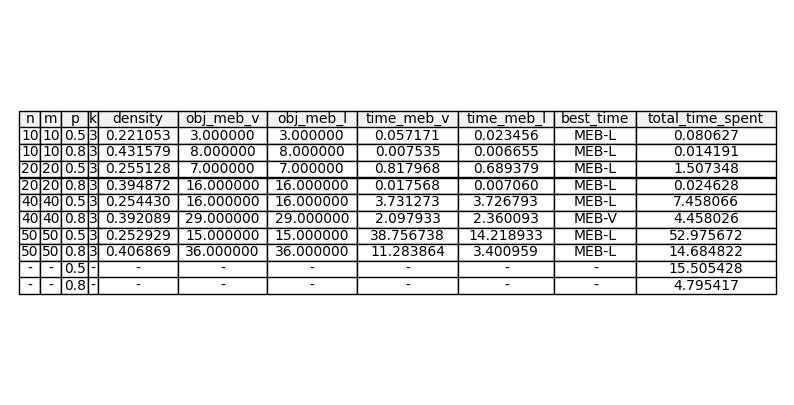

In [18]:
def format_dataframe(df):
    # Limitar o número de casas decimais para colunas numéricas
    for col in ['density', 'obj_meb_v', 'obj_meb_l', 'time_meb_v', 'time_meb_l', 'total_time_spent']:
        df[col] = df[col].apply(lambda x: f'{float(x):.6f}' if isinstance(x, (int, float)) else x)
    return df

def add_total_time_by_p(df):
    # Calculando o total do tempo para p = 0.5 e p = 0.8
    total_time_p_05 = df[df['p'] == 0.5]['total_time_spent'].astype(float).mean()
    total_time_p_08 = df[df['p'] == 0.8]['total_time_spent'].astype(float).mean()

    # Adicionando essas informações como novas linhas
    df_total_time = pd.DataFrame({
        'n': ['-', '-'],
        'm': ['-', '-'],
        'p': [0.5, 0.8],
        'k': ['-', '-'],
        'density': ['-', '-'],
        'obj_meb_v': ['-', '-'],
        'obj_meb_l': ['-', '-'],
        'time_meb_v': ['-', '-'],
        'time_meb_l': ['-', '-'],
        'best_time': ['-', '-'],
        'total_time_spent': [f'{total_time_p_05:.6f}', f'{total_time_p_08:.6f}']
    })

    # Concatenando os DataFrames
    df = pd.concat([df, df_total_time], ignore_index=True)

    return df

def plot_results_table(df):
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))

    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*len(df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    plt.show()

# Formatar o DataFrame
df_formatted = format_dataframe(df_results)

# Adicionar o total de tempo para p = 0.5 e p = 0.8
df_with_totals = add_total_time_by_p(df_formatted)

# Plotar a tabela com os resultados formatados
plot_results_table(df_with_totals)
